<a href="https://colab.research.google.com/github/shakasom/MapsDataScience/blob/master/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter7 - Getting Location Recommender Systems

## Installations

The geospatial libraries are not pre installed in google colab as standard python library, therefore we need to install some libraries to use. Luckily this is an easy process. You can use either apt install or pip install. You can also create anaconda environment, but that is a bit complex so pip and apt are enough in our case to get the libraries we need. These are the libraries we need to install in this tutorial:

Gdal
Geopandas
Folium

The installation might take 1 minute.

In [0]:
%%time 
#!apt update
#!apt upgrade

# GDAL
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium 
# Install Scikit-learn Recommender library Surprise
!pip install scikit-surprise

In [0]:
import pandas as pd
import numpy as np
import random

import geopandas as gpd


import matplotlib.pyplot as plt
import seaborn as sns
import folium

from surprise import Reader
from surprise import Dataset
from surprise import dump

from surprise import BaselineOnly, SVD, SVDpp,  KNNWithMeans,KNNWithZScore, CoClustering, NMF

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from surprise import accuracy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Exploratory Data Analysis (EDA

In [3]:
# Get the data and unzip it
!wget https://www.dropbox.com/s/lust8m4h5qycjsd/RCdata.zip
!unzip RCdata.zip

--2019-05-15 10:37:35--  https://www.dropbox.com/s/lust8m4h5qycjsd/RCdata.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lust8m4h5qycjsd/RCdata.zip [following]
--2019-05-15 10:37:35--  https://www.dropbox.com/s/raw/lust8m4h5qycjsd/RCdata.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc276a8dd987985873354260bcd8.dl.dropboxusercontent.com/cd/0/inline/Ag4LDbb5aMhbj6revpdbGg72PNzJ5iGjWiQP2uxN9G68OU4miaydVKTbjxwOKEGQm_4HevNyIdfTnbxz86qPVb_cEekes7e9Fo8hqC89CV-42A/file# [following]
--2019-05-15 10:37:35--  https://uc276a8dd987985873354260bcd8.dl.dropboxusercontent.com/cd/0/inline/Ag4LDbb5aMhbj6revpdbGg72PNzJ5iGjWiQP2uxN9G68OU4miaydVKTbjxwOKEGQm_4HevNyIdfTnbxz86qPVb_cEekes7e9Fo8hqC89CV-42A/file
Resolving uc276a8dd987985

### Rating

In [4]:
ratings = pd.read_csv('RCdata/rating_final.csv')
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [5]:
ratings.shape

(1161, 5)

1.1998277347114557


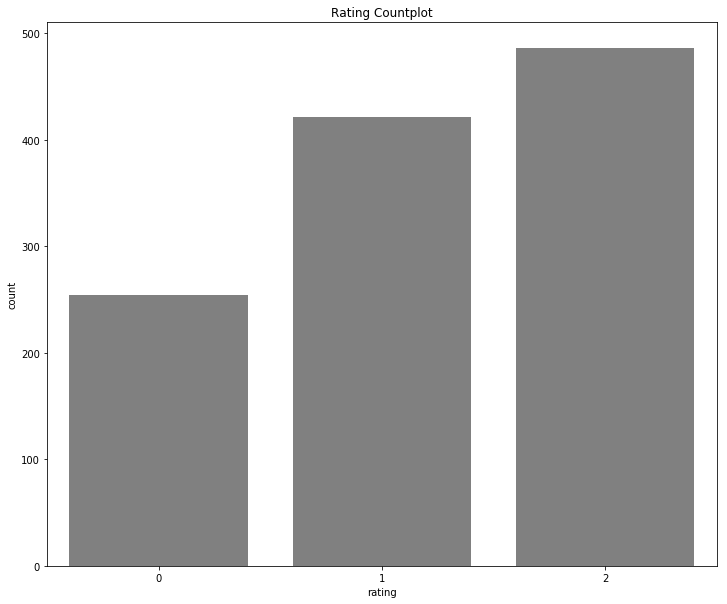

In [6]:
print(ratings['rating'].mean())
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(ratings['rating'], ax=ax, color='grey')
plt.title('Rating Countplot')
plt.savefig('ratingCountPlot.png')
plt.show()

Unique userID and placeID in the dataset. 

In [7]:
print("There are {} unique userID in the dataset".format(ratings['userID'].nunique()))
print("There are {} unique placeID in the dataset".format(ratings['placeID'].nunique()))

There are 138 unique userID in the dataset
There are 130 unique placeID in the dataset


The following are the 10 users with the highest number of ratings. The highest two users have 18 ratings.

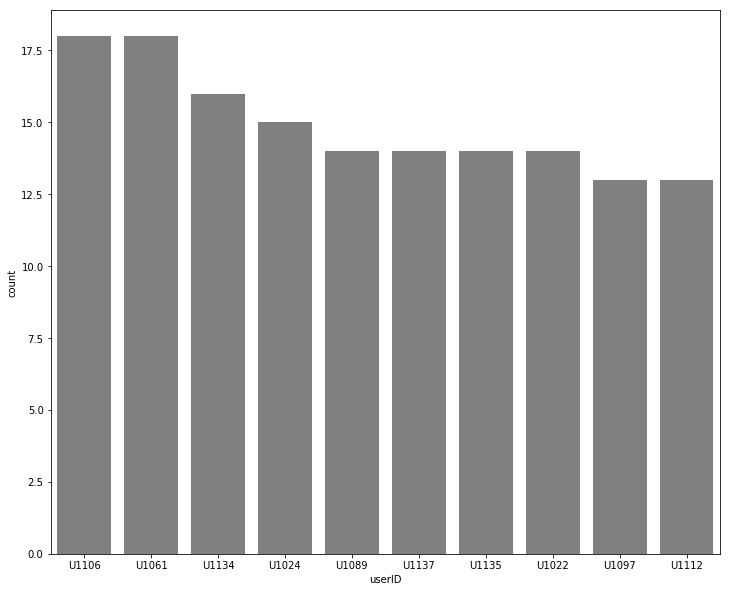

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(x="userID",data=ratings, color="grey", order=ratings['userID'].value_counts().index[:10], ax=ax)
plt.show()

The following are the 10 users with the highest number of ratings. The restaurant with the highest rating count has 36 ratings.

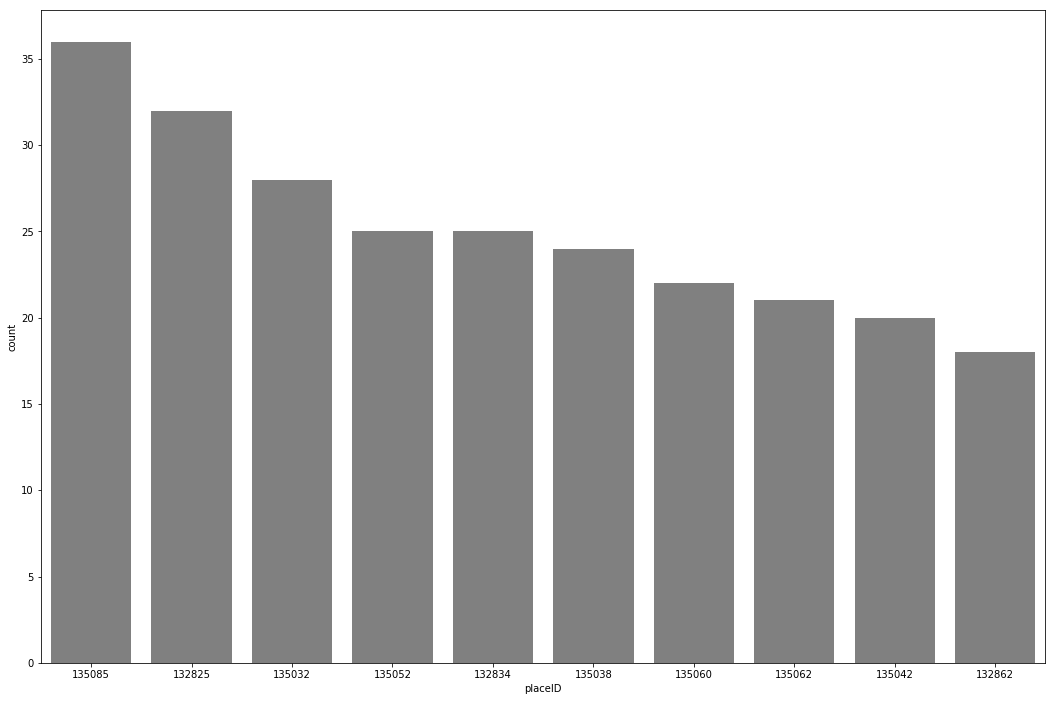

In [9]:
fig, ax = plt.subplots(figsize=(18,12))
sns.countplot(x="placeID",data=ratings, color="grey", order=ratings['placeID'].value_counts().index[:10], ax=ax)
plt.show()

### Restaurants

In [10]:
# Read the data as GeoDataFrame
geoplaces = gpd.read_file('RCdata/geoplaces.geojson')
geoplaces.head(2).T


,0,1
placeID,134999,132825
latitude,18.9154,22.1474
longitude,-99.1849,-100.983
the_geom_meter,0101000020957F000088568DE356715AC138C0A525FC46...,0101000020957F00001AD016568C4858C1243261274BA5...
name,Kiku Cuernavaca,puesto de tacos
address,Revolucion,esquina santos degollado y leon guzman
city,Cuernavaca,s.l.p.
state,Morelos,s.l.p.
country,Mexico,mexico
fax,?,?


In [11]:
geoplaces.shape

(130, 22)

In [12]:
# Display in an interactive map - Folium
m = folium.Map (
    location = [18.915421, -99.184871],
    
    zoom_start = 7
)
folium.GeoJson(geoplaces).add_to(m)

m

In [13]:
from folium.plugins import FastMarkerCluster

lons = geoplaces['longitude'] 
lats = geoplaces['latitude']
m = folium.Map(
    location = [np.mean(geoplaces.latitude), np.mean(geoplaces.longitude)],
    tiles= 'CartoDB dark_matter',
    zoom_start=6
    )
FastMarkerCluster(data=list(zip(lats, lons))).add_to(m)
folium.LayerControl().add_to(m)

m

In [14]:
print("Unique Cities in the dataset is {}".format(geoplaces.city.nunique()))

Unique Cities in the dataset is 17


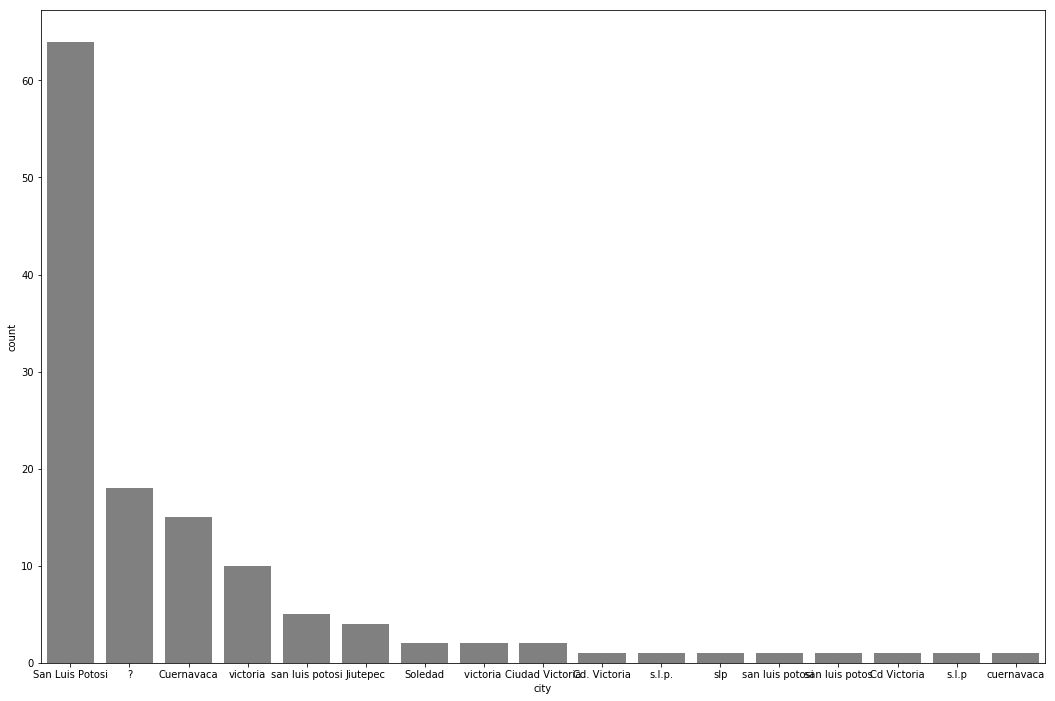

In [15]:

# Display cities in countplot
fig, ax = plt.subplots(figsize=(18,12))
sns.countplot(x="city",data=geoplaces, color="grey", order=geoplaces['city'].value_counts().index, ax=ax)
plt.savefig('citiesCountplot.png')
plt.show()

As you can see there are some mistyped cities with the same name.We need to clean the data. 

In [16]:
# Get the names of unique cities in the dataset
geoplaces['city'].unique()

array(['Cuernavaca', 's.l.p.', 'San Luis Potosi', 'victoria ', 'victoria',
       'Cd Victoria', '?', 'san luis potosi', 'Jiutepec', 'cuernavaca',
       'slp', 'Soledad', 'san luis potos', 'san luis potosi ',
       'Ciudad Victoria', 'Cd. Victoria', 's.l.p'], dtype=object)

In [0]:
# Group each city different names
cuer = ['Cuernavaca', 'cuernavaca', ]
slp = ['s.l.p.',  'San Luis Potosi', 'san luis potosi', 'slp', 'san luis potos', 'san luis potosi ', 's.l.p'] 
ciudad = ['victoria ', 'victoria', 'Cd Victoria', 'Ciudad Victoria', 'Cd. Victoria']

In [0]:
# Replace mistyped names with the right name
geoplaces['city']=geoplaces['city'].replace(slp,'San Luis Potosi' )
geoplaces['city']=geoplaces['city'].replace(ciudad,'Ciudad Victoria')
geoplaces['city']=geoplaces['city'].replace(cuer,'Cuernavaca')

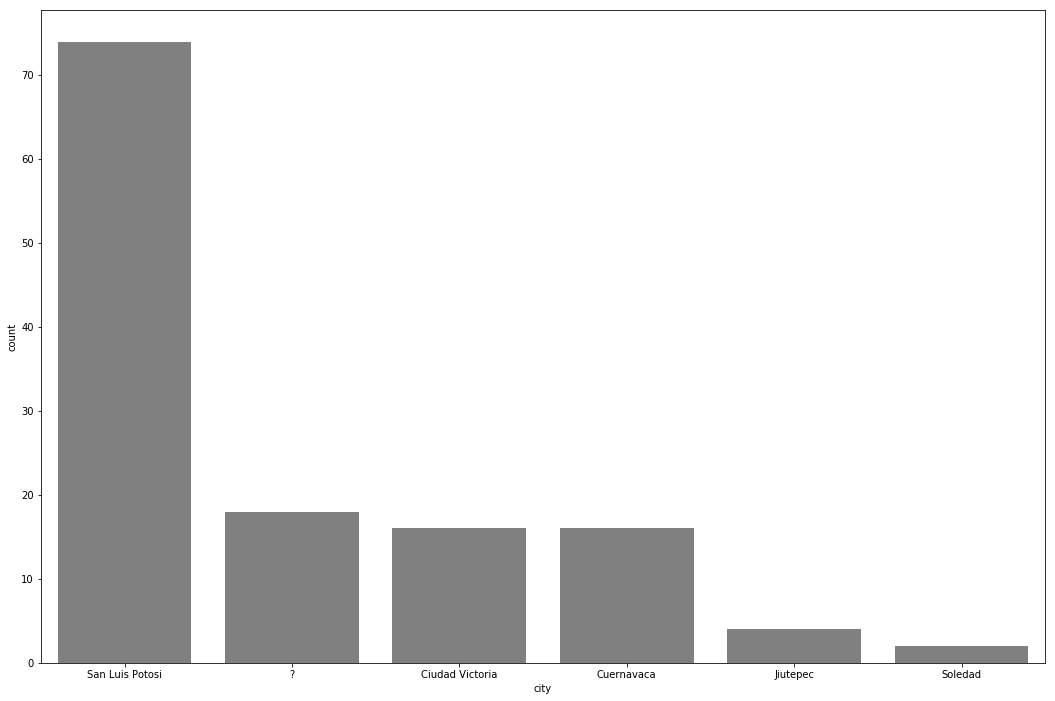

In [19]:
# Display cleaned cities in countplot
fig, ax = plt.subplots(figsize=(18,12))
sns.countplot(x="city",data=geoplaces, color="grey", order=geoplaces['city'].value_counts().index, ax=ax)
plt.show()

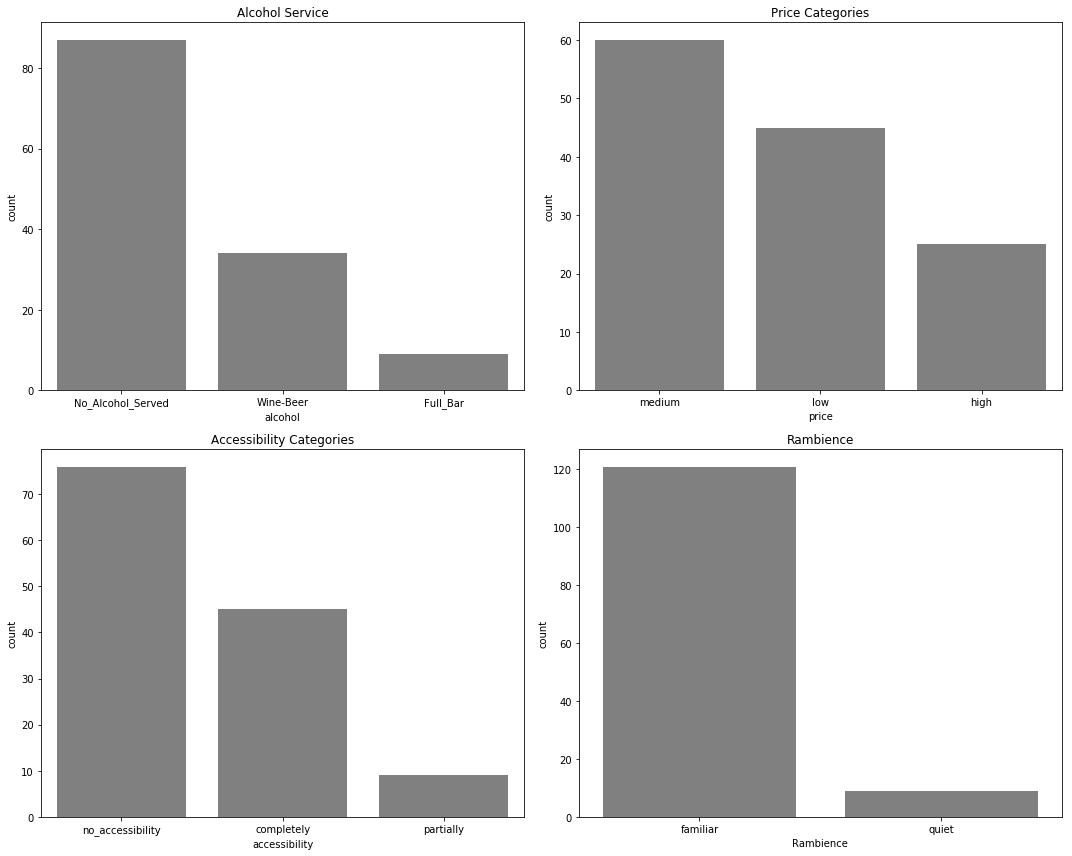

In [20]:
# Subplots for four countplots
fig, ax = plt.subplots(2,2, figsize=(15,12))
sns.countplot(x="alcohol",data=geoplaces, color="grey", ax=ax[0][0])
ax[0][0].set_title('Alcohol Service')
sns.countplot(x="price",data=geoplaces, color="grey", ax=ax[0][1])
ax[0][1].set_title('Price Categories')
sns.countplot(x="accessibility",data=geoplaces, color="grey", ax=ax[1][0])
ax[1][0].set_title('Accessibility Categories')
sns.countplot(x="Rambience",data=geoplaces, color="grey", ax=ax[1][1])
ax[1][1].set_title('Rambience')
#fig.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig('countplot_m.png')
plt.show()

### Merge Ratings & Geoplaces

In [21]:
df = pd.merge(ratings, geoplaces, on='placeID')
df.head()

,userID,placeID,rating,food_rating,service_rating,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,geometry
0,U1077,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,San Luis Potosi,SLP,Mexico,?,78000,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (-100.98268 22.150802)
1,U1108,135085,1,2,1,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,San Luis Potosi,SLP,Mexico,?,78000,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (-100.98268 22.150802)
2,U1081,135085,1,2,1,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,San Luis Potosi,SLP,Mexico,?,78000,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (-100.98268 22.150802)
3,U1056,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,San Luis Potosi,SLP,Mexico,?,78000,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (-100.98268 22.150802)
4,U1134,135085,2,1,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,San Luis Potosi,SLP,Mexico,?,78000,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (-100.98268 22.150802)


In [22]:
df.shape

(1161, 26)

In [23]:
df.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
latitude          0
longitude         0
the_geom_meter    0
name              0
address           0
city              0
state             0
country           0
fax               0
zip               0
alcohol           0
smoking_area      0
dress_code        0
accessibility     0
price             0
url               0
Rambience         0
franchise         0
area              0
other_services    0
geometry          0
dtype: int64

## Recommender Systems 

We will use Surprise, a Python Scikit library for building and analyzing recommender systesm



In [0]:
# Set rating scale of the dataset
reader = Reader(rating_scale=(0, 2))

# Load the dataframe with ratings.
data = Dataset.load_from_df(df[['userID', 'placeID', 'rating']], reader)

In [25]:
benchmark_scores = []


random.seed(114)
np.random.seed(114)

# Iterate selected algorithms
for algorithm in [BaselineOnly(), SVD(), SVDpp(),  KNNWithMeans(),KNNWithZScore(), CoClustering(), NMF()]:
    # Cross-validation
    cv = cross_validate(algorithm, data, cv=5, verbose=False)
    
    # create df with cv results
    df_cv = pd.DataFrame.from_dict(cv).mean(axis=0)
    df_cv = df_cv.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark_scores.append(df_cv)


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
# Create results DataFrame from the benckmark scores
results = pd.DataFrame(benchmark_scores).set_index('Algorithm').sort_values('test_rmse')
results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.657078,0.549815,0.209024,0.004949
KNNWithMeans,0.661444,0.497731,0.002725,0.005682
SVD,0.666097,0.565743,0.066792,0.001960
KNNWithZScore,0.677907,0.502996,0.006953,0.006416
BaselineOnly,0.691530,0.595164,0.002257,0.001552
CoClustering,0.696392,0.516317,0.031733,0.001700
NMF,0.718128,0.549835,0.079612,0.001682


Cross Validation K-Fold

In [0]:


# define a cross-validation iterator
kf = KFold(n_splits=5)

# Define algorithms (Top 2)
algo_knnwithMeans = KNNWithMeans()
algo_svdpp = SVDpp()



    

### KNNWithMeans

In [28]:

random.seed(114)
np.random.seed(114)

for trainset, testset in kf.split(data):

    # train and test algorithm with KNNWithMeans.
    algo_knnwithMeans.fit(trainset)
    predictions_knnwithmeans = algo_knnwithMeans.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions_knnwithmeans, verbose=True)
    
    dump.dump('./dump_KNNWithMeans', predictions_knnwithmeans, algo_knnwithMeans)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6893
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6500
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6478
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6668
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6886


In [29]:
print("Average RMSE of the CV is: ", np.mean(accuracy.rmse(predictions_knnwithmeans, verbose=False)))

Average RMSE of the CV is:  0.688647918600383


Create DataFrame of KNNwithMeans Reuslts


In [0]:
# Load the dump file
predictions_knnwithmeans, algo_knnwithMeans = dump.load('./dump_KNNWithMeans')

In [31]:
df_knnithmeans = pd.DataFrame(predictions_knnwithmeans, columns=['uid', 'iid', 'rui', 'est', 'details'])  
df_knnithmeans.head()

,uid,iid,rui,est,details
0,U1040,134999,1.0,0.983333,"{'actual_k': 2, 'was_impossible': False}"
1,U1032,135042,0.0,1.239111,"{'actual_k': 12, 'was_impossible': False}"
2,U1061,135058,1.0,1.420927,"{'actual_k': 9, 'was_impossible': False}"
3,U1118,134992,0.0,0.000000,"{'actual_k': 2, 'was_impossible': False}"
4,U1019,132856,0.0,0.000000,"{'actual_k': 11, 'was_impossible': False}"


In [32]:
df_knnithmeans.rui.unique()

array([1., 0., 2.])

In [33]:
df_knnithmeans.shape

(232, 5)

In [34]:
# Calculate the error
df_knnithmeans['err'] = abs(df_knnithmeans.est - df_knnithmeans.rui)
df_knnithmeans.head()

,uid,iid,rui,est,details,err
0,U1040,134999,1.0,0.983333,"{'actual_k': 2, 'was_impossible': False}",0.016667
1,U1032,135042,0.0,1.239111,"{'actual_k': 12, 'was_impossible': False}",1.239111
2,U1061,135058,1.0,1.420927,"{'actual_k': 9, 'was_impossible': False}",0.420927
3,U1118,134992,0.0,0.000000,"{'actual_k': 2, 'was_impossible': False}",0.000000
4,U1019,132856,0.0,0.000000,"{'actual_k': 11, 'was_impossible': False}",0.000000


### SVDpp

In [35]:
my_seed = 114
random.seed(my_seed)
np.random.seed(my_seed)

for trainset, testset in kf.split(data):

    # train and test algorithm with SVDpp.
    algo_svdpp.fit(trainset)
    predictions_svdpp = algo_svdpp.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions_svdpp, verbose=True)
    # Dump the prediction into dataframe
    dump.dump('./dump_SVDpp', predictions_svdpp, algo_svdpp)


RMSE: 0.6750
RMSE: 0.6388
RMSE: 0.6159
RMSE: 0.6670
RMSE: 0.6677


In [36]:

print("Average RMSE of the CV is: ", np.mean(accuracy.rmse(predictions_svdpp, verbose=False)))

Average RMSE of the CV is:  0.667695280346118


Create DataFrame of SVDpp Reuslts

In [0]:
# Load the dump file
predictions_svdpp, algo_svdpp = dump.load('./dump_SVDpp')

In [38]:
df_svdpp = pd.DataFrame(predictions_svdpp, columns=['uid', 'iid', 'rui', 'est', 'details'])  
df_svdpp.head()

,uid,iid,rui,est,details
0,U1040,134999,1.0,1.215454,{'was_impossible': False}
1,U1032,135042,0.0,1.300336,{'was_impossible': False}
2,U1061,135058,1.0,1.388325,{'was_impossible': False}
3,U1118,134992,0.0,0.758690,{'was_impossible': False}
4,U1019,132856,0.0,0.232720,{'was_impossible': False}


In [39]:

df_svdpp['err'] = abs(df_svdpp.est - df_svdpp.rui)
df_svdpp.head()

,uid,iid,rui,est,details,err
0,U1040,134999,1.0,1.215454,{'was_impossible': False},0.215454
1,U1032,135042,0.0,1.300336,{'was_impossible': False},1.300336
2,U1061,135058,1.0,1.388325,{'was_impossible': False},0.388325
3,U1118,134992,0.0,0.758690,{'was_impossible': False},0.758690
4,U1019,132856,0.0,0.232720,{'was_impossible': False},0.232720


### Algorithm Comparison and Interpretations

In [40]:
# 10 Worst predictions for KNNwithMeans
df_knnithmeans.sort_values(by='err')[-10:]

,uid,iid,rui,est,details,err
210,U1115,135054,0.0,1.644838,"{'actual_k': 8, 'was_impossible': False}",1.644838
38,U1015,132866,0.0,1.711111,"{'actual_k': 4, 'was_impossible': False}",1.711111
80,U1134,135026,0.0,1.711875,"{'actual_k': 6, 'was_impossible': False}",1.711875
113,U1036,135065,0.0,1.757241,"{'actual_k': 6, 'was_impossible': False}",1.757241
205,U1030,135016,0.0,1.833333,"{'actual_k': 1, 'was_impossible': False}",1.833333
43,U1048,135048,0.0,1.839773,"{'actual_k': 2, 'was_impossible': False}",1.839773
41,U1023,132733,2.0,0.151786,"{'actual_k': 3, 'was_impossible': False}",1.848214
175,U1014,135082,0.0,1.884457,"{'actual_k': 5, 'was_impossible': False}",1.884457
59,U1118,135021,2.0,0.000000,"{'actual_k': 4, 'was_impossible': False}",2.000000
142,U1116,135059,0.0,2.000000,"{'actual_k': 7, 'was_impossible': False}",2.000000


In [41]:
# 10 Worst predictions for SVDpp
df_svdpp.sort_values(by='err')[-10:]

,uid,iid,rui,est,details,err
194,U1027,135066,0.0,1.260576,{'was_impossible': False},1.260576
1,U1032,135042,0.0,1.300336,{'was_impossible': False},1.300336
97,U1005,135043,0.0,1.308369,{'was_impossible': False},1.308369
175,U1014,135082,0.0,1.341835,{'was_impossible': False},1.341835
210,U1115,135054,0.0,1.381919,{'was_impossible': False},1.381919
43,U1048,135048,0.0,1.396731,{'was_impossible': False},1.396731
38,U1015,132866,0.0,1.413020,{'was_impossible': False},1.413020
80,U1134,135026,0.0,1.591442,{'was_impossible': False},1.591442
113,U1036,135065,0.0,1.686855,{'was_impossible': False},1.686855
142,U1116,135059,0.0,1.794109,{'was_impossible': False},1.794109


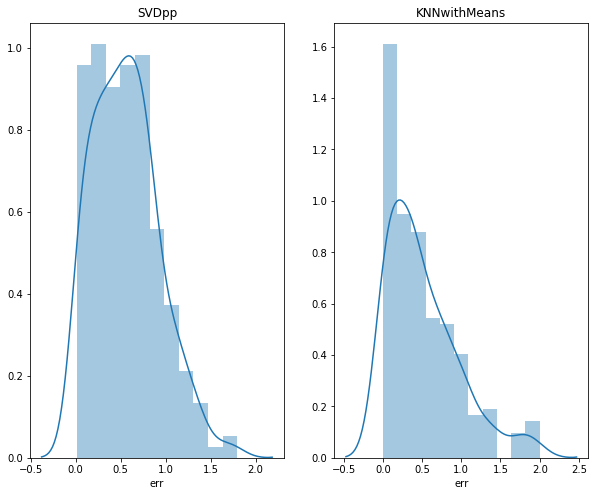

In [42]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
sns.distplot(df_svdpp.err, ax=ax[0])
sns.distplot(df_knnithmeans.err, ax=ax[1])
ax[0].set_title('SVDpp')
ax[1].set_title('KNNwithMeans')
plt.savefig('comparison.png')
plt.show()

* It seems both algorithms are right-skewed. and have higher predictions around zero. So what happens when a user has a smaller number of ratings. Remember we had a mean rating of 1.19. Let us say users with Rating less than 5

In [43]:


def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
df_knnithmeans['Iu'] = df_knnithmeans.uid.apply(get_Iu)
df_svdpp['Iu'] = df_svdpp.uid.apply(get_Iu)

df_knnithmeans[df_knnithmeans.Iu < 5].err.mean(), df_svdpp[df_svdpp.Iu < 5].err.mean()

(0.5104404961856474, 0.580852352863545)

* It seems that KNNwithMeans is doing better in this case than svdpp

## Location Based Recommenders

In [44]:
kmeans = KMeans(n_clusters=24, init='k-means++')


X = df[['longitude','latitude']]
kmeans.fit(X)
y = kmeans.labels_
print("k = 24", " silhouette_score ", silhouette_score(X, y, metric='euclidean'))

k = 24  silhouette_score  0.5407455582206437


In [45]:
df['cluster'] = kmeans.predict(df[['longitude','latitude']])
df[['userID','latitude','longitude','placeID','cluster']].sample(10)

,userID,latitude,longitude,placeID,cluster
96,U1022,22.156883,-100.978485,135060,21
802,U1005,22.151060,-100.977659,135041,3
109,U1098,22.156883,-100.978485,135060,21
669,U1126,22.140129,-100.944872,135069,8
859,U1009,22.145108,-100.989547,135059,12
484,U1065,23.726819,-99.126506,132561,10
228,U1011,23.730925,-99.145185,132564,23
645,U1056,22.153703,-100.979033,135062,21
768,U1019,22.150849,-100.939752,132830,8
1053,U1052,22.141238,-100.923925,132869,4


In [0]:
topvenues_df = df.sort_values(by=['rating', 'food_rating',	'service_rating'], ascending=False)


In [0]:
def recommend_restaurants(df, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
   
    # Get the best restaurant in this cluster
    name = df[df['cluster']==cluster].iloc[0]['name']
   
    print('"{}" is recommended'.format(name))
   

In [0]:
def create_folium_map(df, user_coords, restaurant_name):
    m = folium.Map(
    location=user_coords,
    zoom_start=10,
    tiles='Stamen Terrain'
    )
    
    folium.Marker(
    location=user_coords,
    popup='User Location',
    icon=folium.Icon(icon='cloud')
    ).add_to(m)
    
    
    folium.Marker(
    location=list(df[df['name'] == restaurant_name][['latitude', 'longitude']].iloc[0]),
    popup='Restaurant Location',
    icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)
    
    return m
    

In [49]:
recommend_restaurants(topvenues_df,-99.145185, 23.730925)


"TACOS EL GUERO" is recommended


In [50]:
recommend_restaurants(topvenues_df, -100.939752, 22.150849)

"Rincon Huasteco" is recommended


In [0]:
user_coords = [22.120849, -100.839752]

restaurant_name = "Rincon Huasteco"

In [52]:
create_folium_map(df, user_coords, restaurant_name)

# END